# Bike rent in LA study: maps, frequencies and time series decomposition

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [ ]:
#Importing data

path = r'LABikeData.xlsx'
df = pd.read_excel(path)

After importing and reading the data into Pandas dataframe, we want to take a look at how it looks.

In [3]:
df.describe(include='all')

,trip_id,bike_id,start_station,end_station,trip_route_category,start_time,end_time,start_lat,start_lon,end_lat,end_lon,plan_duration,passholder_type
count,6.397860e+05,639786,639786.000000,596588.000000,639786,639786,639786,638432.000000,638432.000000,630676.000000,630676.000000,639402.000000,639786
unique,NaN,1506,NaN,NaN,2,430642,399786,NaN,NaN,NaN,NaN,NaN,5
top,NaN,4727,NaN,NaN,One Way,14/07/2016 11:38:00 AM,02/12/2018 3:13:00 PM,NaN,NaN,NaN,NaN,NaN,Monthly Pass
freq,NaN,1021,NaN,NaN,547663,15,16,NaN,NaN,NaN,NaN,NaN,367146
mean,6.151973e+07,NaN,3300.809491,3315.452803,NaN,NaN,NaN,34.041273,-118.264491,34.040223,-118.261933,33.621956,NaN
std,3.572124e+07,NaN,480.958424,491.471050,NaN,NaN,NaN,0.246713,0.891939,0.301555,1.035134,72.699619,NaN
min,1.912818e+06,NaN,3000.000000,3000.000000,NaN,NaN,NaN,0.000000,-118.491341,0.000000,-118.491341,0.000000,NaN
25%,2.865659e+07,NaN,3029.000000,3029.000000,NaN,NaN,NaN,34.041130,-118.261169,34.040600,-118.260950,1.000000,NaN
50%,6.380319e+07,NaN,3052.000000,3051.000000,NaN,NaN,NaN,34.046810,-118.252441,34.046612,-118.252831,30.000000,NaN
75%,9.671061e+07,NaN,3082.000000,3082.000000,NaN,NaN,NaN,34.051102,-118.240967,34.050880,-118.238808,30.000000,NaN


Let's convert the date and time from string to pandas datetime format:

In [4]:

from dateutil import parser
df['start_time_dt'] = pd.to_datetime(df['start_time'], dayfirst=True)
df['end_time_dt'] = pd.to_datetime(df['end_time'],dayfirst=True)
df['trip_dur'] = df['end_time_dt'] - df['start_time_dt']
#expressing duration of the trip in hours
df['trip_dur'] = (df.trip_dur).astype('timedelta64[m]')

The amount of unique values for monthly pass is one more than shown in the dictionary. What is the excess one?

In [5]:
df.groupby('passholder_type')['trip_id'].agg(len)

passholder_type
Annual Pass       2057
Flex Pass        25160
Monthly Pass    367146
One Day Pass     23319
Walk-up         222104
Name: trip_id, dtype: int64

What percentage of trips is one-way?

In [6]:
totalTrips = len(df)
sameStationTrips = df[df.trip_route_category == 'One Way']

print ('Total number of trips: {:,}'.format(totalTrips))
print (('Trips from A -> A: {:,}').format(len(sameStationTrips)))
print (('Trips from A -> A: {:.1%}').format(len(sameStationTrips) / totalTrips))

Total number of trips: 639,786
Trips from A -> A: 547,663
Trips from A -> A: 85.6%


Now, let's look at the durations

In [7]:
df['trip_dur'].describe()

count    639786.000000
mean         38.336319
std         177.449996
min         -56.000000
25%           7.000000
50%          12.000000
75%          24.000000
max        8849.000000
Name: trip_dur, dtype: float64

Clearly, something is wrong with negative durations. Let's count how many of them we have

In [8]:
df['negative_dur'] = df['trip_dur'].apply(lambda x: x > 0)
df['negative_dur'].value_counts()

True     639779
False         7
Name: negative_dur, dtype: int64

In [9]:
df_neg = df.loc[df['negative_dur'] == False]
df_neg = df_neg[['start_time', 'end_time', 'trip_dur']]
df_neg.tail()

,start_time,end_time,trip_dur
283120,05/11/2017 1:56:00 AM,05/11/2017 1:08:00 AM,-48.0
283121,05/11/2017 1:54:00 AM,05/11/2017 1:08:00 AM,-46.0
283122,05/11/2017 1:51:00 AM,05/11/2017 1:07:00 AM,-44.0
283628,05/11/2017 1:56:00 AM,05/11/2017 1:02:00 AM,-54.0
300702,05/11/2017 1:59:00 AM,05/11/2017 1:03:00 AM,-56.0


As seen above, the end times are earlier than start times. Must be a glitch. We exclude these observations from analysis.

In [10]:
df1 = df.loc[df['negative_dur'] == True]


df1 = df1[df['start_lon'] < 0]


df1.describe()

C:\Users\agleo\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


,trip_id,start_station,end_station,start_lat,start_lon,end_lat,end_lon,plan_duration,trip_dur
count,6.383920e+05,638392.000000,595213.000000,638392.000000,638392.000000,629800.000000,629800.000000,638022.000000,638392.000000
mean,6.148728e+07,3301.410049,3315.905007,34.042979,-118.270790,34.041294,-118.265687,33.621425,38.252600
std,3.572472e+07,481.248850,491.712786,0.052744,0.082833,0.232944,0.792992,72.694683,177.524326
min,1.912818e+06,3005.000000,3000.000000,33.710979,-118.491341,0.000000,-118.491341,0.000000,1.000000
25%,2.862683e+07,3030.000000,3029.000000,34.041130,-118.261169,34.040600,-118.260950,1.000000,7.000000
50%,6.379265e+07,3052.000000,3051.000000,34.046810,-118.252441,34.046612,-118.252831,30.000000,12.000000
75%,9.662850e+07,3082.000000,3082.000000,34.051102,-118.240967,34.050880,-118.238808,30.000000,24.000000
max,1.127323e+08,4276.000000,4276.000000,34.165291,-118.116530,34.165291,0.000000,365.000000,8849.000000


In [11]:

from datetime import date
df1['start_time_day_name'] = df1['start_time_dt'].dt.weekday_name
df1['start_time_hour'] = df1['start_time_dt'].dt.hour
df_rides_day2 = pd.pivot_table(df1[['start_time_day_name', 'start_time_hour', 'trip_dur']], index=['start_time_day_name', 'start_time_hour'], aggfunc='count')
df_rides_day3 = df_rides_day2.unstack(level=0)
df_rides_day3 = df_rides_day3.reindex(labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], axis=1, level=1)

In [12]:
morning_hours = []
for hour in range(1, 12):
    detailed_hour = str(hour) + "am"
    morning_hours.append(detailed_hour)

afternoon_hours = []
for hour in range(1, 12):
    detailed_hour = str(hour) + "pm"
    afternoon_hours.append(detailed_hour)

detailed_hours = ["12am"] + morning_hours + ["12pm"] + afternoon_hours

day_short_names = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']


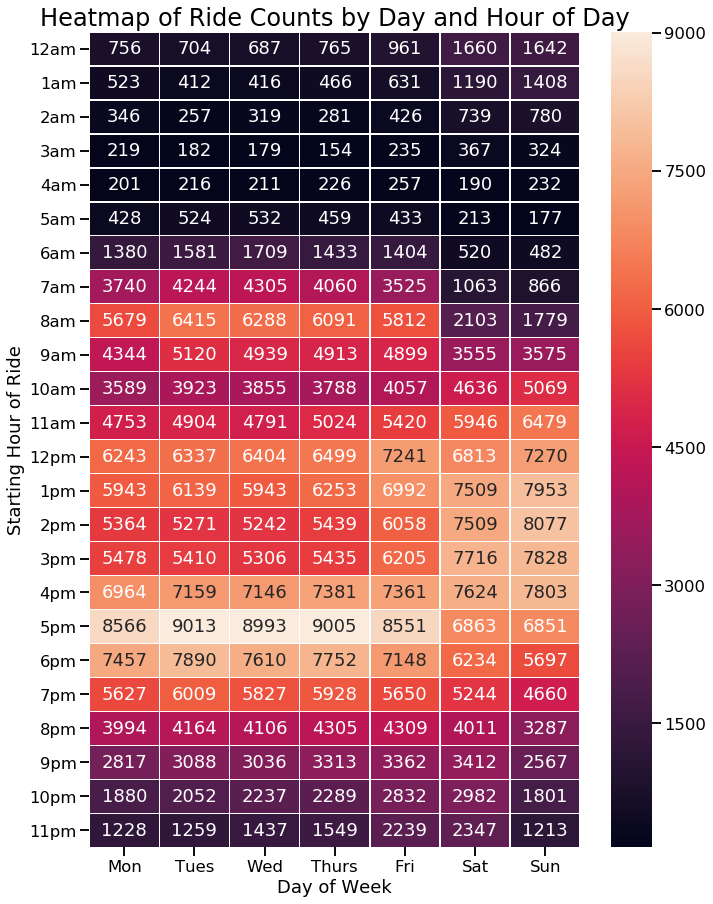

In [13]:
sns.set_context("talk")
f, ax = plt.subplots(figsize=(11, 15))
ax = sns.heatmap(df_rides_day3, annot=True, fmt="d", linewidths=.5, ax=ax, xticklabels=day_short_names, yticklabels=detailed_hours)
ax.axes.set_title("Heatmap of Ride Counts by Day and Hour of Day", fontsize=24, y=1.01)
ax.set(xlabel='Day of Week', ylabel='Starting Hour of Ride');

In [14]:
df1['start_time_month'] = df1['start_time_dt'].dt.month
df1['start_time_year'] = df1['start_time_dt'].dt.year
df_rides_day4 = pd.pivot_table(df1[['start_time_month', 'start_time_year', 'trip_dur']], index=['start_time_month'], columns = ['start_time_year'],aggfunc='count')
df_rides_day4

trip_dur                  
start_time_year      2016     2017     2018
start_time_month                           
1                     NaN  10346.0  22206.0
2                     NaN   9527.0  19968.0
3                     NaN  13884.0  23159.0
4                     NaN  13848.0  24838.0
5                     NaN  19338.0  26097.0
6                     NaN  18667.0  26335.0
7                 11410.0  22044.0  30341.0
8                 24137.0  25198.0  33319.0
9                 19860.0  25036.0  31064.0
10                18150.0  27627.0  28898.0
11                14423.0  22613.0  23949.0
12                10606.0  20532.0  20972.0

Text(0.5, 1.01, 'Heatmap of Ride Counts by Month and Year')

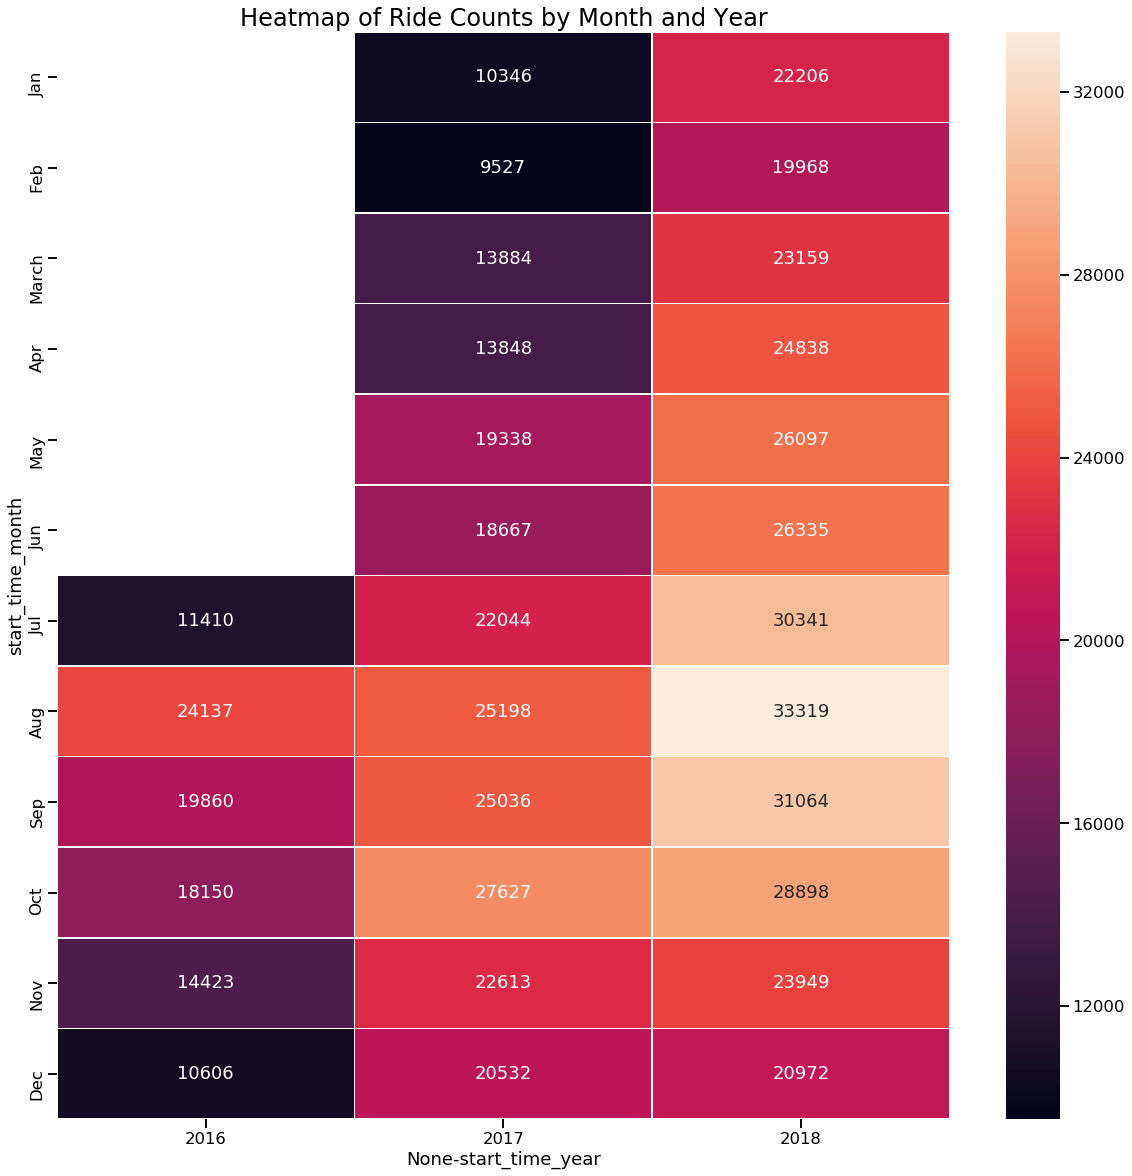

In [15]:
month_short_names = ['Jan', 'Feb', 'March', 'Apr', 'May', 'Jun', 'Jul', 'Aug','Sep', 'Oct', 'Nov', 'Dec']
years_names = [2016, 2017, 2018]
f, ax = plt.subplots(figsize=(20, 20))
ax = sns.heatmap(df_rides_day4, annot=True, linewidths=.5, ax=ax, yticklabels = month_short_names, xticklabels=years_names, fmt=".0f")
ax.axes.set_title("Heatmap of Ride Counts by Month and Year", fontsize=24, y=1.01)


In [16]:
df1['trip_start_date'] = df1['start_time_dt'].dt.date
df_rides_day5 = pd.pivot_table(df1[['trip_start_date', 'trip_dur']], index=['trip_start_date'],aggfunc='count')
df_rides_day5.head(3)

,trip_dur
trip_start_date,
2016-07-07,190
2016-07-08,344
2016-07-09,421


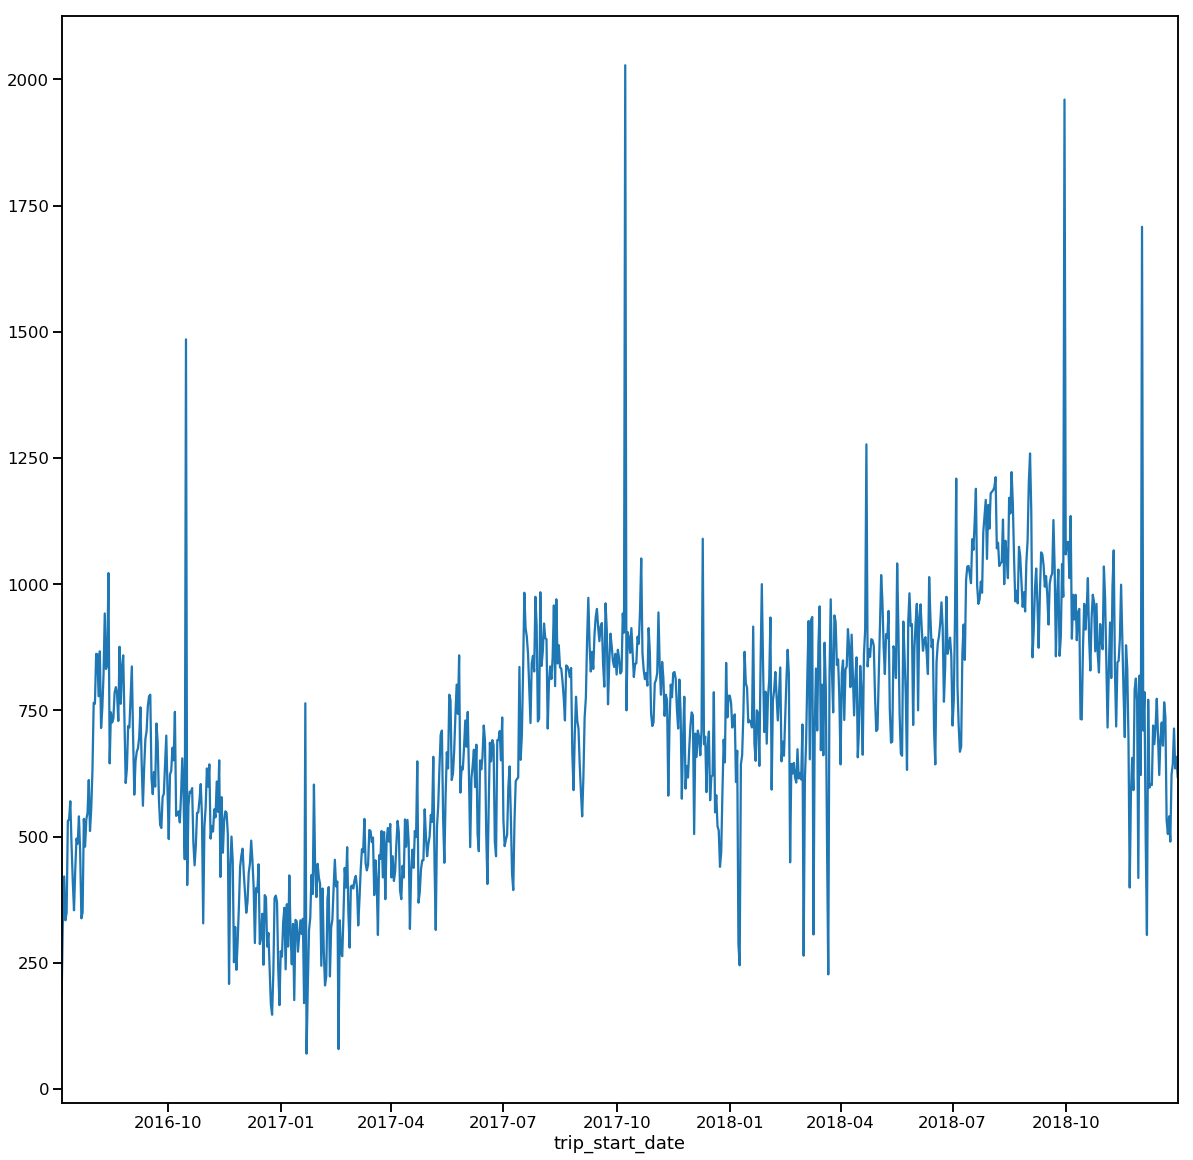

In [17]:
df_rides_day5['trip_dur'].plot(figsize = (20,20))
df_rides_day5.to_csv('daily_rides.csv')

Now, let's visualize the starting locations on the interactive map.

In [18]:
import folium
from folium import plugins
df1.head()

,trip_id,bike_id,start_station,end_station,trip_route_category,start_time,end_time,start_lat,start_lon,end_lat,...,passholder_type,start_time_dt,end_time_dt,trip_dur,negative_dur,start_time_day_name,start_time_hour,start_time_month,start_time_year,trip_start_date
0,1912818,6281,3014,3014.0,Round Trip,07/07/2016 4:17:00 AM,07/07/2016 4:20:00 AM,34.056610,-118.23721,34.056610,...,Monthly Pass,2016-07-07 04:17:00,2016-07-07 04:20:00,3.0,True,Thursday,4,7,2016,2016-07-07
1,1919661,6281,3014,3014.0,Round Trip,07/07/2016 6:00:00 AM,07/07/2016 6:33:00 AM,34.056610,-118.23721,34.056610,...,Monthly Pass,2016-07-07 06:00:00,2016-07-07 06:33:00,33.0,True,Thursday,6,7,2016,2016-07-07
2,1933383,5861,3016,3016.0,Round Trip,07/07/2016 10:32:00 AM,07/07/2016 10:37:00 AM,34.052898,-118.24156,34.052898,...,Flex Pass,2016-07-07 10:32:00,2016-07-07 10:37:00,5.0,True,Thursday,10,7,2016,2016-07-07
3,1944197,5861,3016,3016.0,Round Trip,07/07/2016 10:37:00 AM,07/07/2016 1:38:00 PM,34.052898,-118.24156,34.052898,...,Flex Pass,2016-07-07 10:37:00,2016-07-07 13:38:00,181.0,True,Thursday,10,7,2016,2016-07-07
4,1940317,6674,3032,3032.0,Round Trip,07/07/2016 12:51:00 PM,07/07/2016 12:58:00 PM,34.049889,-118.25588,34.049889,...,Walk-up,2016-07-07 12:51:00,2016-07-07 12:58:00,7.0,True,Thursday,12,7,2016,2016-07-07


In [19]:
def map_points(df, lat_col='start_lat', lon_col='start_lon', zoom_start=11, \
                plot_points=False, pt_radius=15, \
                draw_heatmap=False, heat_map_weights_col=None, \
                heat_map_weights_normalize=True, heat_map_radius=15):
    """Creates a map given a dataframe of points. Can also produce a heatmap overlay

    Arg:
        df: dataframe containing points to maps
        lat_col: Column containing latitude (string)
        lon_col: Column containing longitude (string)
        zoom_start: Integer representing the initial zoom of the map
        plot_points: Add points to map (boolean)
        pt_radius: Size of each point
        draw_heatmap: Add heatmap to map (boolean)
        heat_map_weights_col: Column containing heatmap weights
        heat_map_weights_normalize: Normalize heatmap weights (boolean)
        heat_map_radius: Size of heatmap point

    Returns:
        folium map object
    """

    ## center map in the middle of points center in
    middle_lat = df[lat_col].median()
    middle_lon = df[lon_col].median()

    curr_map = folium.Map(location=[middle_lat, middle_lon],
                          zoom_start=zoom_start)

    # add points to map
    if plot_points:
        for _, row in df.iterrows():
            folium.CircleMarker([row[lat_col], row[lon_col]],
                                radius=pt_radius,
                                popup=row['start_station'],
                                fill_color="#3db7e4", # divvy color
                               ).add_to(curr_map)

    # add heatmap
    if draw_heatmap:
        # convert to (n, 2) or (n, 3) matrix format
        if heat_map_weights_col is None:
            cols_to_pull = [lat_col, lon_col]
        else:
            # if we have to normalize
            if heat_map_weights_normalize:
                df[heat_map_weights_col] = \
                    df[heat_map_weights_col] / df[heat_map_weights_col].sum()

            cols_to_pull = [lat_col, lon_col, heat_map_weights_col]

        stations = df[cols_to_pull].as_matrix()
        curr_map.add_children(plugins.HeatMap(stations, radius=heat_map_radius))

    return curr_map

In [20]:
StationCountsByStationID = df1.groupby('start_station')['trip_id'].agg('count')
StationCountsByStationID.name = 'numTrips'
StationCountsByStationID = StationCountsByStationID.to_frame()
StationCountsByStationID.reset_index(inplace = True)

StationCountsByStationID.head(20)

,start_station,numTrips
0,3005,25000
1,3006,11450
2,3007,11928
3,3008,9588
4,3009,56
5,3010,1504
6,3011,5825
7,3013,188
8,3014,19328
9,3016,5366


In [21]:
Stations = df1[['start_station', 'start_lat', 'start_lon']]
Stations = Stations.drop_duplicates(subset ="start_station",keep ='first')
Stations.set_index("start_station", inplace = True) 
Stations.sort_index(inplace = True)
Stations.reset_index(inplace = True)
Stations.head(16)

,start_station,start_lat,start_lon
0,3005,34.048550,-118.259050
1,3006,34.045540,-118.256670
2,3007,34.050480,-118.254590
3,3008,34.046612,-118.262730
4,3009,33.987381,-118.472832
5,3010,34.037048,-118.254870
6,3011,34.041130,-118.267980
7,3013,33.779819,-118.263023
8,3014,34.056610,-118.237210
9,3016,34.052898,-118.241560


In [22]:
sameStationCountsDF = pd.merge(Stations, StationCountsByStationID, on="start_station")

sameStationCountsDF.dropna(inplace = True)
#sameStationCountsDF = sameStationCountsDF.drop(columns=['index'])
sameStationCountsDF

,start_station,start_lat,start_lon,numTrips
0,3005,34.048550,-118.259050,25000
1,3006,34.045540,-118.256670,11450
2,3007,34.050480,-118.254590,11928
3,3008,34.046612,-118.262730,9588
4,3009,33.987381,-118.472832,56
5,3010,34.037048,-118.254870,1504
6,3011,34.041130,-118.267980,5825
7,3013,33.779819,-118.263023,188
8,3014,34.056610,-118.237210,19328
9,3016,34.052898,-118.241560,5366


Now, let's make an easier map, but with time series built in

In [23]:
def generateBaseMap(default_location=[34.048550,-118.259050], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [24]:
from folium.plugins import HeatMap
df_copy = df1.copy()
df_copy['count'] = 1
df_copy = df_copy[df_copy['start_lat']>0]
base_map = generateBaseMap()
HeatMap(data=df_copy[['start_lat', 'start_lon', 'count']].groupby(['start_lat', 'start_lon']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)
base_map

In [25]:
df1['month_year'] = pd.to_datetime(df1['start_time_dt']).dt.to_period('M')
df_copy = df1.copy()
df_copy['count'] = 1

In [26]:
df_copy.describe()

,trip_id,start_station,end_station,start_lat,start_lon,end_lat,end_lon,plan_duration,trip_dur,start_time_hour,start_time_month,start_time_year,count
count,6.383920e+05,638392.000000,595213.000000,638392.000000,638392.000000,629800.000000,629800.000000,638022.000000,638392.000000,638392.000000,638392.000000,638392.000000,638392.0
mean,6.148728e+07,3301.410049,3315.905007,34.042979,-118.270790,34.041294,-118.265687,33.621425,38.252600,14.080228,7.344929,2017.332962,1.0
std,3.572472e+07,481.248850,491.712786,0.052744,0.082833,0.232944,0.792992,72.694683,177.524326,4.765798,3.150881,0.728667,0.0
min,1.912818e+06,3005.000000,3000.000000,33.710979,-118.491341,0.000000,-118.491341,0.000000,1.000000,0.000000,1.000000,2016.000000,1.0
25%,2.862683e+07,3030.000000,3029.000000,34.041130,-118.261169,34.040600,-118.260950,1.000000,7.000000,11.000000,5.000000,2017.000000,1.0
50%,6.379265e+07,3052.000000,3051.000000,34.046810,-118.252441,34.046612,-118.252831,30.000000,12.000000,14.000000,8.000000,2017.000000,1.0
75%,9.662850e+07,3082.000000,3082.000000,34.051102,-118.240967,34.050880,-118.238808,30.000000,24.000000,18.000000,10.000000,2018.000000,1.0
max,1.127323e+08,4276.000000,4276.000000,34.165291,-118.116530,34.165291,0.000000,365.000000,8849.000000,23.000000,12.000000,2018.000000,1.0


In [27]:
df_hour_list2 = []
for month_year in df_copy.month_year.sort_values().unique():
    df_hour_list2.append(df_copy.loc[df_copy.month_year == month_year, ['start_lat', 'start_lon', 'count']].groupby(['start_lat', 'start_lon']).sum().reset_index().values.tolist())
    

In [28]:
from folium.plugins import HeatMapWithTime
base_map = generateBaseMap(default_zoom_start=11)
HeatMapWithTime(df_hour_list2,  radius=8, gradient={0.1: 'blue', 0.3: 'lime', 0.5: 'orange', 1: 'red'}, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(base_map)


In [29]:
base_map
base_map.save('heatmap_timev3.html')

In [30]:
df_3 = df_copy


In [32]:
import geopandas
from shapely.geometry import Point
df_3['geometry'] = df_3.apply(lambda row: Point(row['start_lon'], row['start_lat']), axis=1)

In [33]:
geo_bike_data = geopandas.GeoDataFrame(df_3, geometry='geometry')

In [34]:
sf = geopandas.read_file('la-county.geojson')
sf.head(4)

,kind,external_id,name,slug,set,metadata,resource_uri,geometry
0,L.A. County Neighborhood (V6),acton,Acton,acton-la-county-neighborhood-v6,/1.0/boundary-set/la-county-neighborhoods-v6/,"{'city': '', 'name': 'Acton', 'region': 'antel...",/1.0/boundary/acton-la-county-neighborhood-v6/,(POLYGON ((-118.2070340000001 34.5390230000001...
1,L.A. County Neighborhood (V6),adams-normandie,Adams-Normandie,adams-normandie-la-county-neighborhood-v6,/1.0/boundary-set/la-county-neighborhoods-v6/,"{'city': 'los-angeles', 'name': 'Adams-Normand...",/1.0/boundary/adams-normandie-la-county-neighb...,"(POLYGON ((-118.3080020000001 34.037396, -118...."
2,L.A. County Neighborhood (V6),agoura-hills,Agoura Hills,agoura-hills-la-county-neighborhood-v6,/1.0/boundary-set/la-county-neighborhoods-v6/,"{'city': '', 'name': 'Agoura Hills', 'region':...",/1.0/boundary/agoura-hills-la-county-neighborh...,(POLYGON ((-118.7762120000001 34.1681570000001...
3,L.A. County Neighborhood (V6),agua-dulce,Agua Dulce,agua-dulce-la-county-neighborhood-v6,/1.0/boundary-set/la-county-neighborhoods-v6/,"{'city': '', 'name': 'Agua Dulce', 'region': '...",/1.0/boundary/agua-dulce-la-county-neighborhoo...,(POLYGON ((-118.3782240000001 34.4881090000001...


In [35]:
sf = sf.rename(columns={'geometry': 'geometry'}).set_geometry('geometry')

In [36]:
combined = geopandas.tools.sjoin(geo_bike_data, sf, how='left')
combined.sample(5)

C:\Users\agleo\Anaconda3\lib\site-packages\geopandas\tools\sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


,trip_id,bike_id,start_station,end_station,trip_route_category,start_time,end_time,start_lat,start_lon,end_lat,...,count,geometry,index_right,kind,external_id,name,slug,set,metadata,resource_uri
620122,110611310,6049,3027,3027.0,Round Trip,02/12/2018 12:12:00 PM,02/12/2018 2:28:00 PM,34.049980,-118.247162,34.049980,...,1,POINT (-118.247162 34.04998),70,L.A. County Neighborhood (V6),downtown,Downtown,downtown-la-county-neighborhood-v6,/1.0/boundary-set/la-county-neighborhoods-v6/,"{'city': 'los-angeles', 'name': 'Downtown', 'r...",/1.0/boundary/downtown-la-county-neighborhood-v6/
190295,34718420,6220,3030,3082.0,One Way,12/07/2017 11:18:00 AM,12/07/2017 11:23:00 AM,34.051941,-118.243530,34.046520,...,1,POINT (-118.24353 34.051941),70,L.A. County Neighborhood (V6),downtown,Downtown,downtown-la-county-neighborhood-v6,/1.0/boundary-set/la-county-neighborhoods-v6/,"{'city': 'los-angeles', 'name': 'Downtown', 'r...",/1.0/boundary/downtown-la-county-neighborhood-v6/
194180,35446279,5983,3069,3049.0,One Way,17/07/2017 7:06:00 PM,17/07/2017 7:11:00 PM,34.050880,-118.248253,34.056969,...,1,POINT (-118.248253 34.05088),70,L.A. County Neighborhood (V6),downtown,Downtown,downtown-la-county-neighborhood-v6,/1.0/boundary-set/la-county-neighborhoods-v6/,"{'city': 'los-angeles', 'name': 'Downtown', 'r...",/1.0/boundary/downtown-la-county-neighborhood-v6/
542995,104985811,6352,3067,3023.0,One Way,09/09/2018 1:37:00 PM,09/09/2018 1:53:00 PM,34.045181,-118.250237,34.050911,...,1,POINT (-118.250237 34.045181),70,L.A. County Neighborhood (V6),downtown,Downtown,downtown-la-county-neighborhood-v6,/1.0/boundary-set/la-county-neighborhoods-v6/,"{'city': 'los-angeles', 'name': 'Downtown', 'r...",/1.0/boundary/downtown-la-county-neighborhood-v6/
307104,56766291,6052,4183,4147.0,One Way,07/11/2017 5:28:00 PM,07/11/2017 5:52:00 PM,34.146069,-118.129180,34.145248,...,1,POINT (-118.12918 34.146069),203,L.A. County Neighborhood (V6),pasadena,Pasadena,pasadena-la-county-neighborhood-v6,/1.0/boundary-set/la-county-neighborhoods-v6/,"{'city': '', 'name': 'Pasadena', 'region': 've...",/1.0/boundary/pasadena-la-county-neighborhood-v6/


In [37]:
combined = geopandas.tools.sjoin(geo_bike_data, sf, how='left')

C:\Users\agleo\Anaconda3\lib\site-packages\geopandas\tools\sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


In [38]:
combined['name'].describe()

count       638392
unique          14
top       Downtown
freq        460651
Name: name, dtype: object

In [39]:
combined.name.unique()

array(['Downtown', 'Westlake', 'Chinatown', 'Historic South-Central',
       'Venice', 'Culver City', 'Pasadena', 'Wilmington', 'San Pedro',
       'Santa Monica', 'Echo Park', 'Exposition Park', 'University Park',
       'Boyle Heights'], dtype=object)

In [40]:
south =['Wilmington', 'San Pedro']
west = ['Venice','Santa Monica', 'Culver City']
north = ['Pasadena']
central = ['Downtown', 'Westlake', 'Chinatown',  'Historic South-Central', 'Echo Park', 'Exposition Park', 'University Park',
       'Boyle Heights']

In [41]:
south_df = combined[combined['name'].isin(south)]
west_df = combined[combined['name'].isin(west)]
north_df = combined[combined['name'].isin(north)]
central_df = combined[combined['name'].isin(central)]


In [42]:
south1 = pd.pivot_table(south_df[['trip_start_date', 'trip_dur']], index=['trip_start_date'],aggfunc='count')
west1 = pd.pivot_table(west_df[['trip_start_date', 'trip_dur']], index=['trip_start_date'],aggfunc='count')
north1 = pd.pivot_table(north_df[['trip_start_date', 'trip_dur']], index=['trip_start_date'],aggfunc='count')
central1 = pd.pivot_table(central_df[['trip_start_date', 'trip_dur']], index=['trip_start_date'],aggfunc='count')

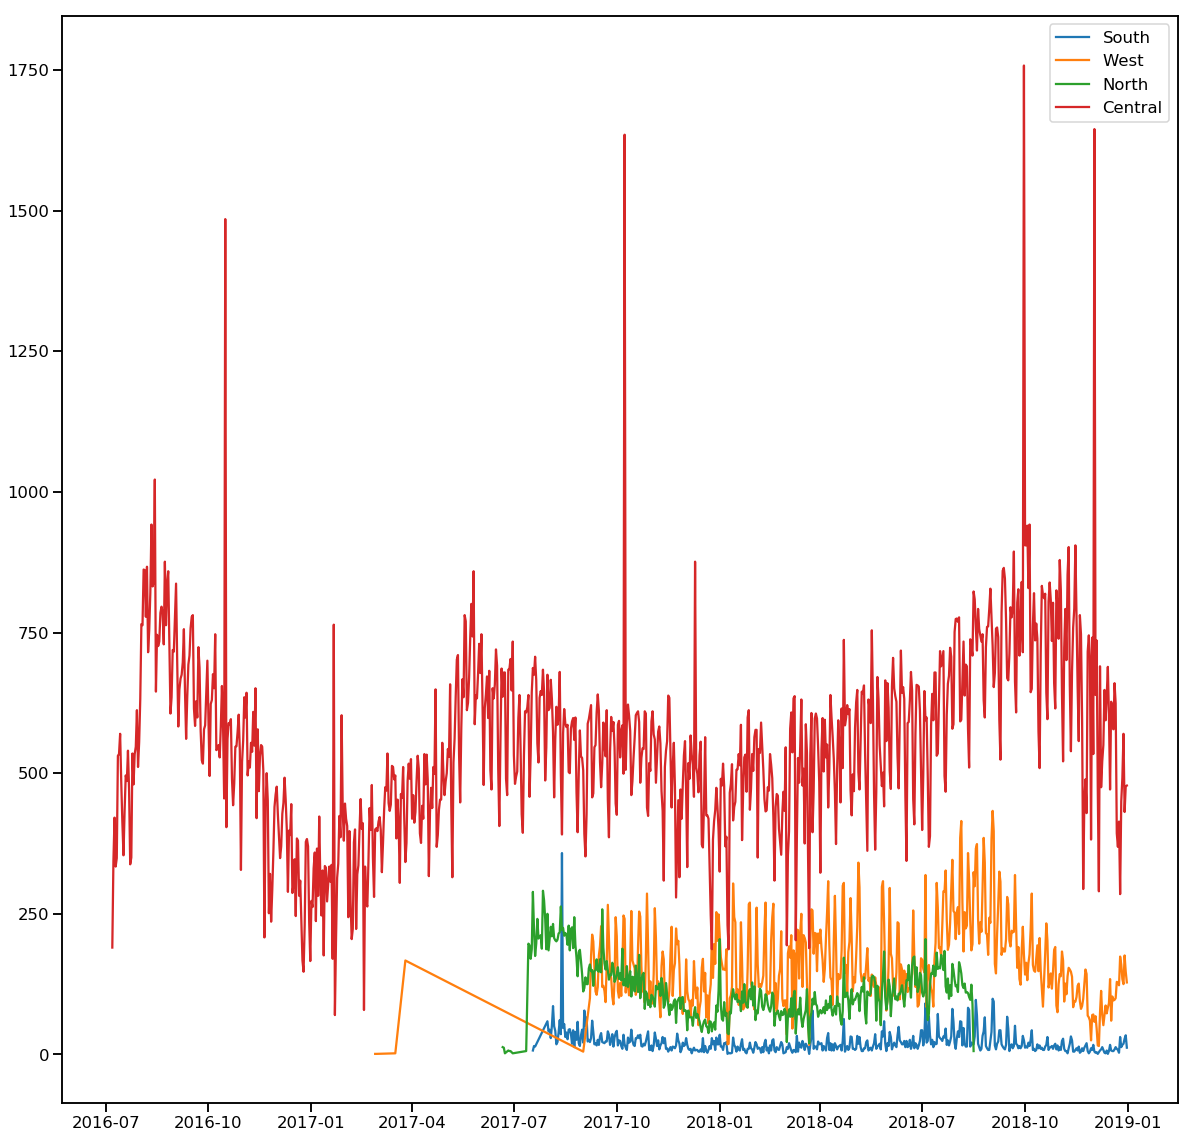

In [43]:

plt.figure(figsize=(20,20))
plt.plot(south1['trip_dur'], label ='South')
plt.plot(west1['trip_dur'], label = 'West')
plt.plot(north1['trip_dur'], label = 'North')
plt.plot(central1['trip_dur'], label = 'Central')
plt.legend()

In [44]:
df2 = combined[combined.trip_route_category == 'One Way']
south_df2 = df2[df2['name'].isin(south)]
west_df2 = df2[df2['name'].isin(west)]
north_df2 = df2[combined['name'].isin(north)]
central_df2= df2[df2['name'].isin(central)]


C:\Users\agleo\Anaconda3\lib\site-packages\geopandas\geodataframe.py:455: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)


In [45]:
combined_c = pd.pivot_table(df2[['trip_start_date', 'trip_dur']], index=['trip_start_date'],aggfunc='count')
south2 = pd.pivot_table(south_df2[['trip_start_date', 'trip_dur']], index=['trip_start_date'],aggfunc='count')
west2= pd.pivot_table(west_df2[['trip_start_date', 'trip_dur']], index=['trip_start_date'],aggfunc='count')
north2 = pd.pivot_table(north_df2[['trip_start_date', 'trip_dur']], index=['trip_start_date'],aggfunc='count')
central2 = pd.pivot_table(central_df2[['trip_start_date', 'trip_dur']], index=['trip_start_date'],aggfunc='count')

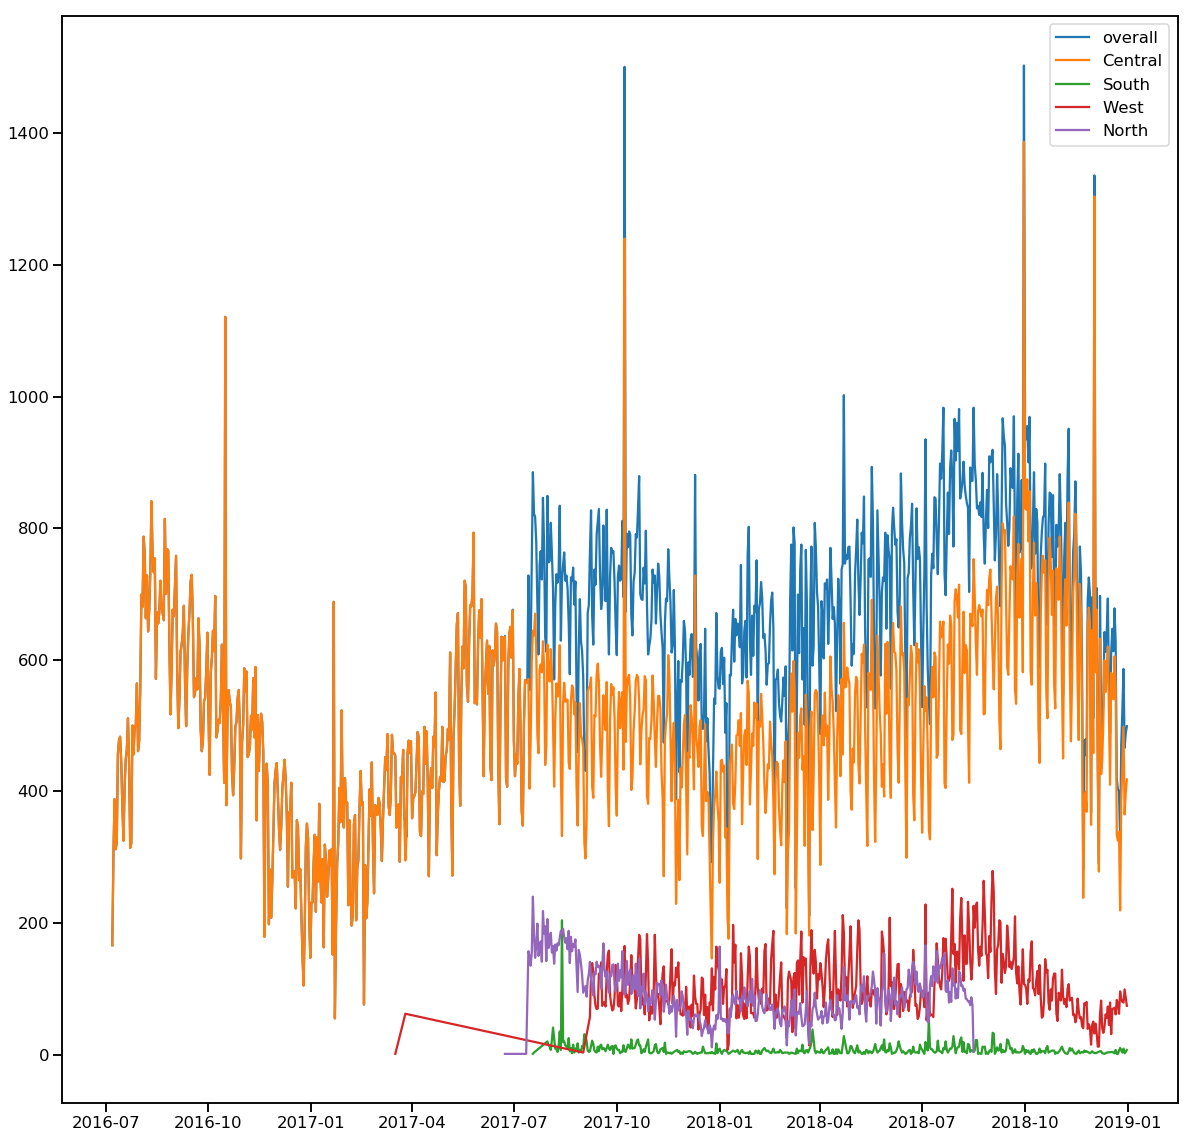

In [46]:
plt.figure(figsize=(20,20))
plt.plot(combined_c['trip_dur'], label ='overall')
plt.plot(central2['trip_dur'], label = 'Central')
plt.plot(south2['trip_dur'], label ='South')
plt.plot(west2['trip_dur'], label = 'West')
plt.plot(north2['trip_dur'], label = 'North')
plt.legend()

In [50]:
import statsmodels.api  as sm
combined2 = pd.pivot_table(df2[['trip_start_date', 'trip_dur']], index=['trip_start_date'],aggfunc='count')
#combined2.index=combined2.index.to_timestamp()
combined2.interpolate(inplace=True)
decomposition = sm.tsa.seasonal_decompose(combined2, model='additive', freq=30)

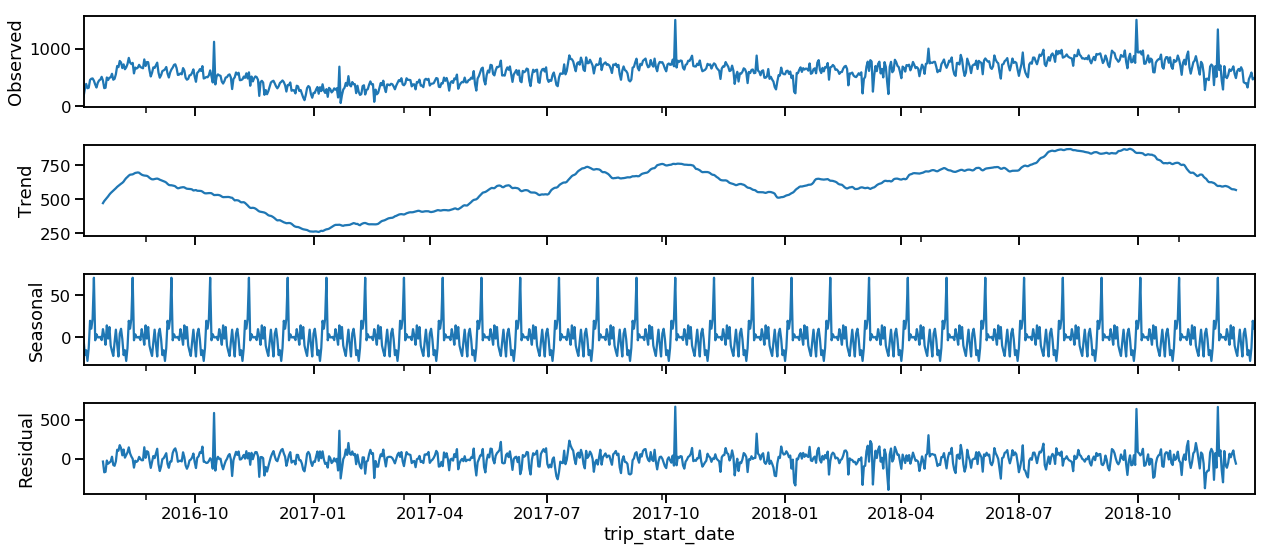

In [51]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
fig = decomposition.plot()
plt.show()

In [52]:
central2 = pd.pivot_table(central_df2[['trip_start_date', 'trip_dur']], index=['trip_start_date'],aggfunc='count')
#central2.index=central2.index.to_timestamp('M')
central2.interpolate(inplace=True)
decomposition2 = sm.tsa.seasonal_decompose(central2, model='additive', freq=30)


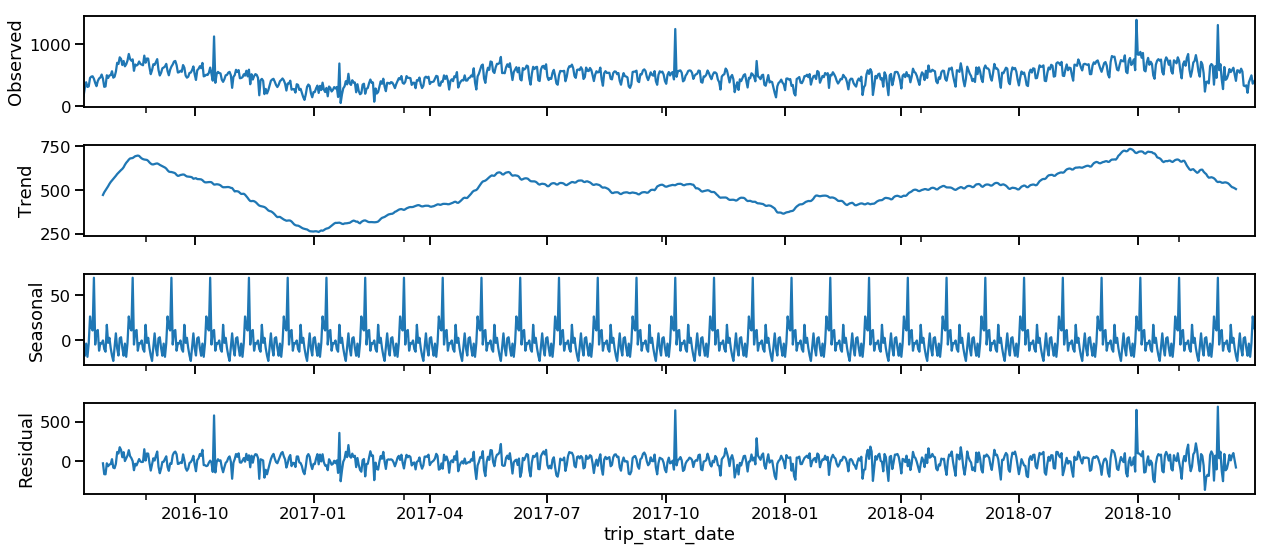

In [53]:
decomposition2.plot()
plt.show()

In [54]:
west2 = pd.pivot_table(west_df2[['trip_start_date', 'trip_dur']], index=['trip_start_date'],aggfunc='count')
#west2.index=west2.index.to_timestamp()
west2.interpolate(inplace=True)
decomposition3 = sm.tsa.seasonal_decompose(west2, model='additive', freq=30)


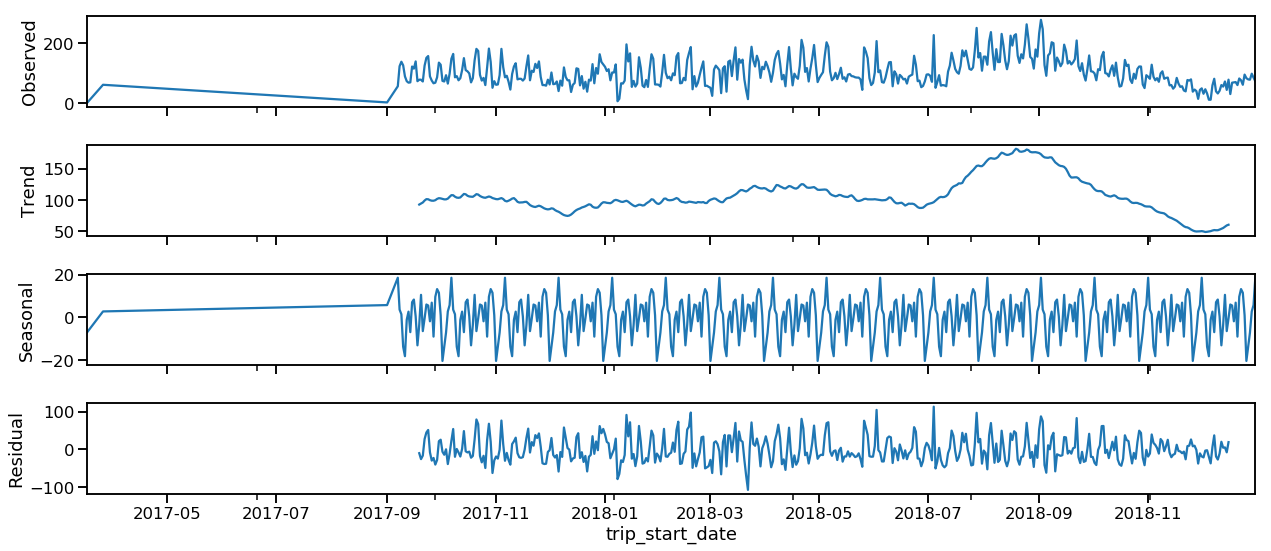

In [55]:
decomposition3.plot()
plt.show()

In [56]:
north2 = pd.pivot_table(north_df2[['trip_start_date', 'trip_dur']], index=['trip_start_date'],aggfunc='count')
#west2.index=west2.index.to_timestamp()
north2.interpolate(inplace=True)
decomposition4 = sm.tsa.seasonal_decompose(north2, model='additive', freq=30)


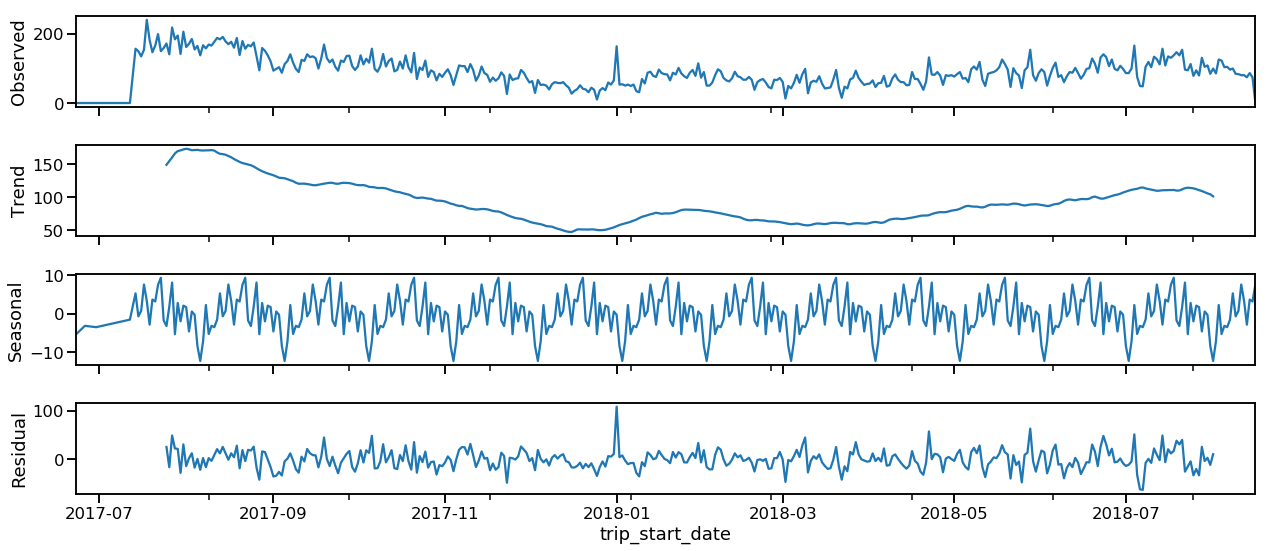

In [57]:
decomposition4.plot()
plt.show()

In [58]:
south2 = pd.pivot_table(south_df2[['trip_start_date', 'trip_dur']], index=['trip_start_date'],aggfunc='count')
#west2.index=west2.index.to_timestamp()
south2.interpolate(inplace=True)
decomposition5 = sm.tsa.seasonal_decompose(south2, model='additive', freq=30)


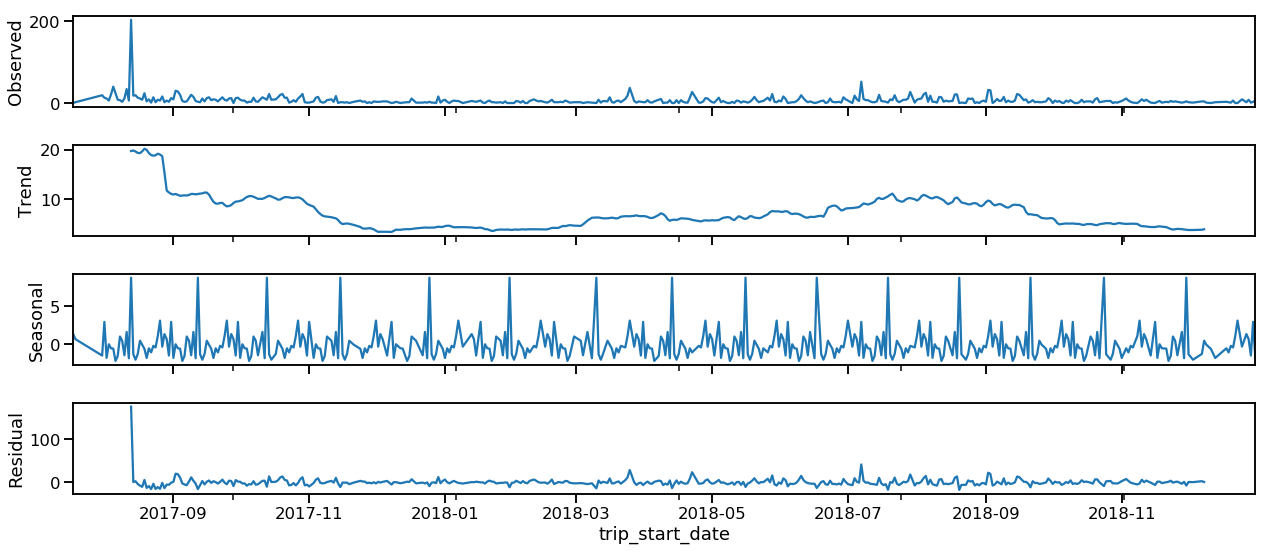

In [59]:
decomposition5.plot()
plt.show()